<a href="https://colab.research.google.com/github/yangste333/Homelessness_Analysis/blob/main/Homelessness_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The 2020 [point-in-time count](https://www.kingcounty.gov/elected/executive/constantine/news/release/2020/July/01-homeless-count.aspx) of people experiencing homelessness for Seattle/King County was 11,751. This represents a 5% increase over the 2019 count and reflects similar trend across many counties in the western U.S.. A step towards addressing homelessness is improving our understanding of the relationship between local housing market factors and homelessness. 

The U.S. Department of Housing and Urban Development (HUD) produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) that describes a model-based approach to understanding of the relationship between local housing market factors and homelessness. Our project is motivated by the goals of the HUD study:

"To continue progressing toward the goals of ending and preventing homelessness, we must further our knowledge of the basic community-level determinants of homelessness. The primary objectives of this study are to (1) identify market factors that have established effects on homelessness, (2) construct and evaluate empirical models of community-level homelessness.."

We will investigate whether there are alternative modeling approaches that outperform the models described in the HUD report.


## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

## The data

The [data](https://github.com/yangste333/Homelessness_Analysis/blob/main/data/05b_analysis_file_update.csv) for this project are described in HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

The data dictionary [HUD TO3 - 05b Analysis File - Data Dictionary.csv](https://github.com/yangste333/Homelessness_Analysis/blob/main/data/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv) contains descriptions of all variables in the data set.




## Load the data

In [2]:

data = pd.read_csv("https://raw.githubusercontent.com/yangste333/Homelessness_Analysis/main/data/05b_analysis_file_update.csv")

## Explore the contents of the data set

In [3]:
data.head()

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_rent75,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,3,1,1,1,1,0,0
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,0,3,1,1,1,1,0,0
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,3,1,1,1,1,0,0
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,0,3,1,1,1,1,0,0
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,3,1,1,1,1,0,0


In [4]:
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 332 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    year                              int64  
 1    cocnumber                         object 
 2    pit_tot_shelt_pit_hud             float64
 3    pit_tot_unshelt_pit_hud           float64
 4    pit_tot_hless_pit_hud             float64
 5    pit_ind_shelt_pit_hud             float64
 6    pit_ind_unshelt_pit_hud           float64
 7    pit_ind_hless_pit_hud             float64
 8    pit_perfam_shelt_pit_hud          float64
 9    pit_perfam_unshelt_pit_hud        float64
 10   pit_perfam_hless_pit_hud          float64
 11   pit_ind_chronic_hless_pit_hud     float64
 12   pit_perfam_chronic_hless_pit_hud  float64
 13   pit_vet_hless_pit_hud             float64
 14   econ_urb_urbanicity               int64  
 15   coctag                            int64  
 16   panelvar              

We're planning to predict the values that are part of the predictors of homelessness - sheltered homeless, unsheltered homeless, and total homeless.


### Explore the data sources

Use the dictionary to find the unique `Associated Domain` values.

In [5]:
data_dict = pd.read_csv('https://raw.githubusercontent.com/yangste333/Homelessness_Analysis/main/data/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv')

In [6]:
data_dict

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN
...,...,...,...,...,...,...
327,Subgroup,sub_west_coast_all_urb,indicator for suburban or major city/largely u...,No,NaN,NaN
328,Subgroup,sub_west_census,indicator for west region CoCs,No,NaN,NaN
329,Subgroup,major_city,indicator for major city or largely urban CoC,No,HUD,NaN
330,Subgroup,suburban,indicator for largely suburban CoC,No,HUD,NaN


In [7]:
data_dict['Associated Domain'].unique()

array(['Identifier', 'Outcome', 'Secondary Outcome', 'Subgroup',
       'Safety Net', 'Demographic', 'Housing', 'Economic', 'Local Policy',
       'Climate', 'Geography'], dtype=object)

Text(0.5, 1.0, 'Types of Associated Domain')

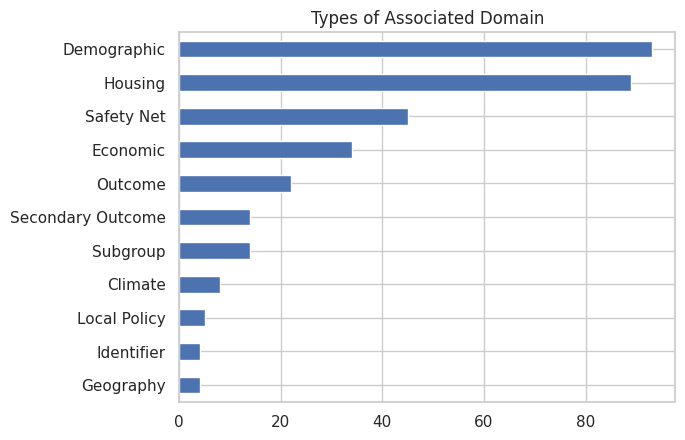

In [8]:
data_dict['Associated Domain'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('Types of Associated Domain')

Text(0.5, 1.0, 'Sources')

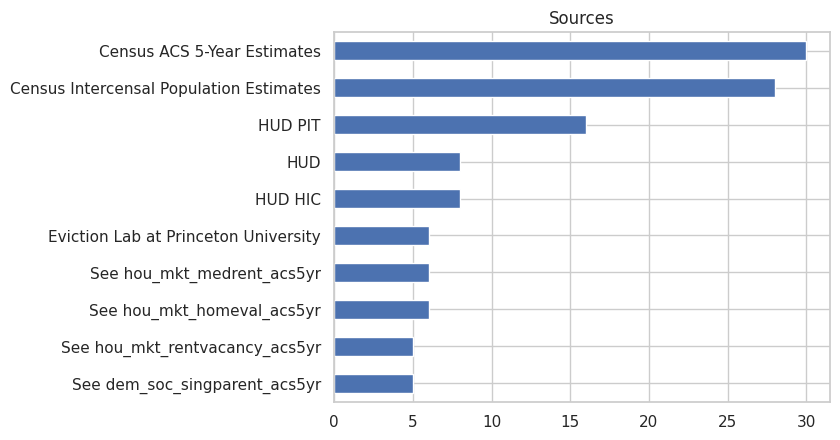

In [9]:
data_dict['Source or Root Variable'].value_counts().head(10).plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('Sources')

## Convert data types, if necessary

We don't have any data that needs to be changed in terms of data type.

## Select relevant subsets of the data

We will explore a subset of the full data set. 

For now, we will keep at least the following columns. We might include more columns later, though.

In [10]:
columns_to_keep = ["year", "cocnumber",
  
                  "pit_tot_hless_pit_hud", "pit_tot_shelt_pit_hud", "pit_tot_unshelt_pit_hud","dem_pop_pop_census",
  
                  "fhfa_hpi_2009", "ln_hou_mkt_medrent_xt", "hou_mkt_utility_xt", "hou_mkt_burden_own_acs5yr_2017", "hou_mkt_burden_sev_rent_acs_2017", "hou_mkt_rentshare_acs5yr_2017", "hou_mkt_rentvacancy_xt", "hou_mkt_density_dummy", "hou_mkt_evict_count", "hou_mkt_ovrcrowd_acs5yr_2017", "major_city", "suburban",
           
                  "econ_labor_unemp_rate_BLS", "econ_labor_incineq_acs5yr_2017", "econ_labor_pov_pop_census_share",
           
                  "hou_pol_hudunit_psh_hud_share", "hou_pol_occhudunit_psh_hud", "hou_mkt_homeage1940_xt",
           
                  "dem_soc_black_census", "dem_soc_hispanic_census", "dem_soc_asian_census", "dem_soc_pacific_census", "dem_pop_child_census", "dem_pop_senior_census", "dem_pop_female_census", "dem_pop_mig_census", "d_dem_pop_mig_census_share", "dem_soc_singadult_xt", "dem_soc_singparent_xt", "dem_soc_vet_xt", "dem_soc_ed_lessbach_xt", "dem_health_cost_dart", "dem_health_excesdrink_chr",
           
                  "env_wea_avgtemp_noaa", "env_wea_avgtemp_summer_noaa", "env_wea_precip_noaa", "env_wea_precip_annual_noaa"]
    

Some other things to note that may or may not be added in the future:
- Median household income - since income may be related to ability to afford housing, for example.
- Total number of housing units - how available affordable housing could be in the area
- CPI, or Consumer Price Index - how much the prices change over a given time; could mean that housing prices are more/less affordable?

In [11]:
filtered_data = data[columns_to_keep]
filtered_data

,year,cocnumber,pit_tot_hless_pit_hud,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,dem_pop_pop_census,fhfa_hpi_2009,ln_hou_mkt_medrent_xt,hou_mkt_utility_xt,hou_mkt_burden_own_acs5yr_2017,...,dem_soc_singadult_xt,dem_soc_singparent_xt,dem_soc_vet_xt,dem_soc_ed_lessbach_xt,dem_health_cost_dart,dem_health_excesdrink_chr,env_wea_avgtemp_noaa,env_wea_avgtemp_summer_noaa,env_wea_precip_noaa,env_wea_precip_annual_noaa
0,2010,AK-500,1231.0,1113.0,118.0,285194,0.000000,NaN,NaN,15.334315,...,NaN,NaN,NaN,NaN,7.788850,NaN,18.400000,56.599998,0.680000,12.560000
1,2011,AK-500,1223.0,1082.0,141.0,293370,0.009359,2.266958,9.300000,15.334315,...,24.832815,21.773510,17.234230,66.952057,7.850010,NaN,18.799999,55.799999,0.520000,15.560000
2,2012,AK-500,1147.0,1097.0,50.0,296291,-0.049137,NaN,NaN,15.334315,...,NaN,NaN,NaN,NaN,7.905940,NaN,2.900000,55.900002,1.170000,16.459999
3,2013,AK-500,1122.0,1070.0,52.0,298520,-0.255042,2.266958,9.300000,15.334315,...,24.832815,21.773510,17.234230,66.952057,7.831980,NaN,23.299999,56.000000,1.100000,20.270000
4,2014,AK-500,1023.0,970.0,53.0,301081,3.170481,NaN,NaN,15.334315,...,NaN,NaN,NaN,NaN,7.957180,NaN,30.299999,60.099998,1.520000,24.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003,2013,WY-500,953.0,501.0,452.0,576608,-3.997063,1.801716,11.087501,11.688841,...,27.254406,18.938293,14.075889,74.912552,8.326384,NaN,21.424429,67.280464,0.609694,10.513665
3004,2014,WY-500,757.0,563.0,194.0,582341,-1.707775,NaN,NaN,11.688841,...,NaN,NaN,NaN,NaN,8.002878,NaN,24.127457,65.757263,0.893619,16.595993
3005,2015,WY-500,798.0,507.0,291.0,583334,1.682674,1.941027,11.694517,11.688841,...,27.971273,19.368048,11.996357,73.547821,8.215987,NaN,26.539898,62.469509,0.540197,17.857925
3006,2016,WY-500,857.0,491.0,366.0,586102,5.077799,NaN,NaN,11.688841,...,NaN,NaN,NaN,NaN,8.653676,NaN,23.763687,64.416168,0.796616,17.125946


In [12]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              3008 non-null   int64  
 1   cocnumber                         3008 non-null   object 
 2   pit_tot_hless_pit_hud             2994 non-null   float64
 3   pit_tot_shelt_pit_hud             2994 non-null   float64
 4   pit_tot_unshelt_pit_hud           2994 non-null   float64
 5   dem_pop_pop_census                3008 non-null   int64  
 6   fhfa_hpi_2009                     3008 non-null   float64
 7   ln_hou_mkt_medrent_xt             1504 non-null   float64
 8   hou_mkt_utility_xt                1504 non-null   float64
 9   hou_mkt_burden_own_acs5yr_2017    3008 non-null   float64
 10  hou_mkt_burden_sev_rent_acs_2017  3008 non-null   float64
 11  hou_mkt_rentshare_acs5yr_2017     3008 non-null   float64
 12  hou_mk

If we look at the data points we chose:


In [13]:
filtered_data_dict = data_dict[data_dict['Variable'].isin(columns_to_keep)]

In [14]:
filtered_data_dict

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN
32,Demographic,dem_pop_pop_census,"total population, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
34,Demographic,dem_pop_female_census,"total female population, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
35,Demographic,dem_pop_child_census,"total population ages 0-19, intercensal estimate",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
37,Demographic,dem_pop_senior_census,"total population ages 65 or older, intercensal...",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."
39,Demographic,dem_soc_black_census,"total black alone (non-hispanic) population, i...",No,Census Intercensal Population Estimates,"""Annual County Resident Population Estimates b..."


Text(0.5, 1.0, 'Types of Associated Domain')

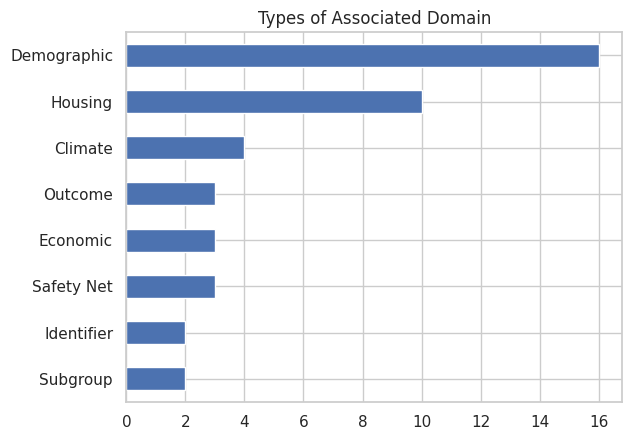

In [15]:
filtered_data_dict['Associated Domain'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('Types of Associated Domain')

Text(0.5, 1.0, 'Sources')

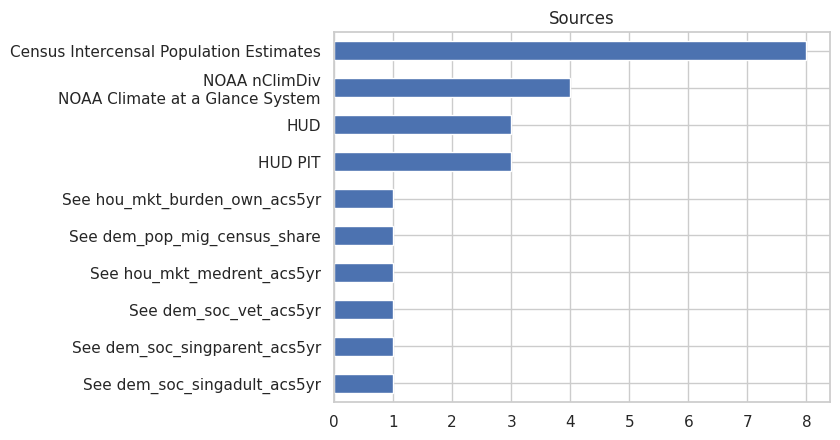

In [16]:
filtered_data_dict['Source or Root Variable'].value_counts().head(10).plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('Sources')

## Are the data suitable for answering the question?

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. If the data are not sufficient, we do not want to waste time doing anything that will not be productive.

<ipython-input-17-b7204698f488>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(filtered_data.dropna().corr(), vmin=-1, vmax=1)


<Axes: >

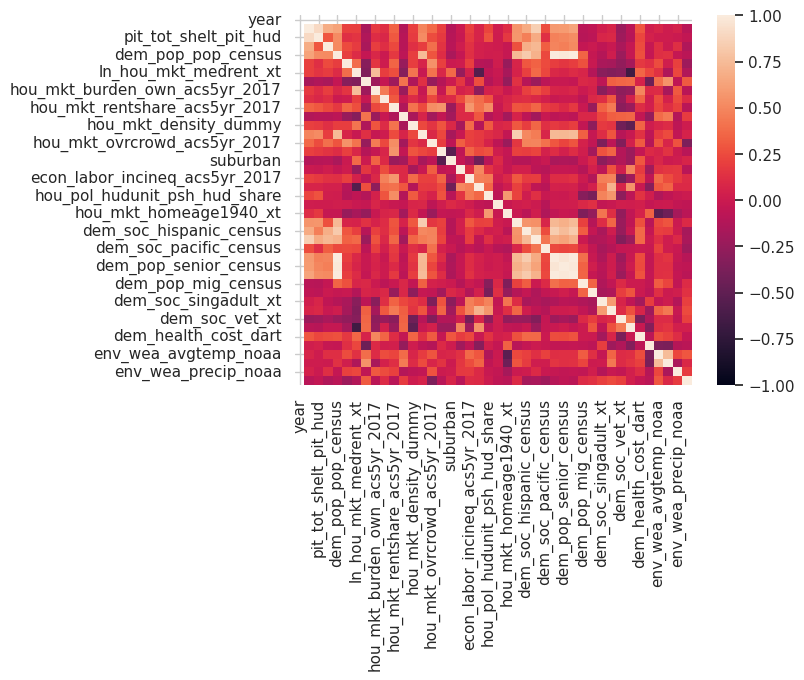

In [17]:
sns.heatmap(filtered_data.dropna().corr(), vmin=-1, vmax=1)

It looks like some of the values are more important than others. There might be something here.

## Identify and deal with missing values

If we look at the missing data, it looks a bit weird:

<Axes: >

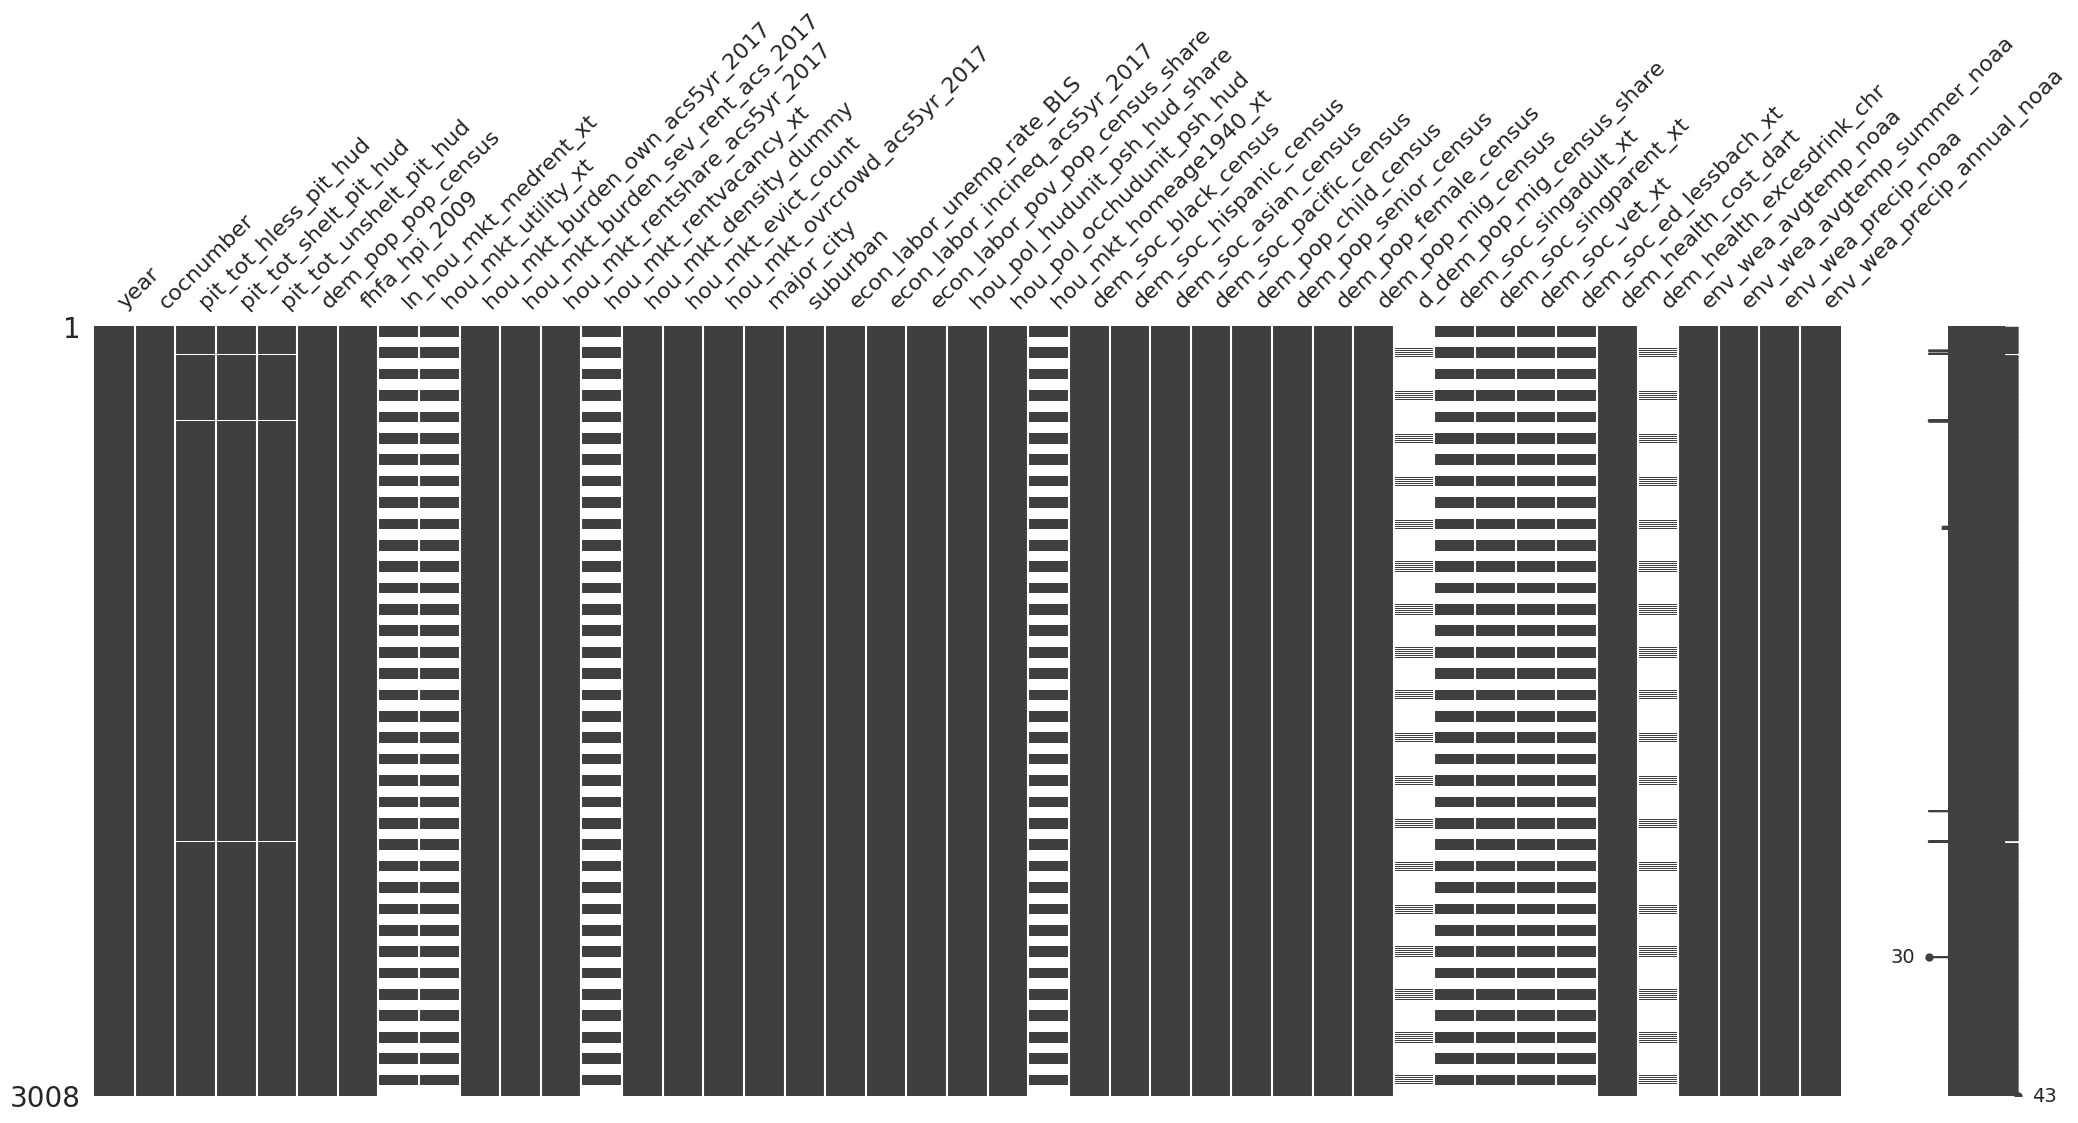

In [18]:
msno.matrix(filtered_data)

It looks like some years are just missing data, and that some data is concentrated in a specific year.

We would have problems if the "total homeless" amounts were unknown - after all, that's what we're trying to predict! - so we should probably remove data points where that's null. It just so happens that the three null values that are missing in the number of homeless all happen to be missing from the same three points, so we can just pick one of the factors to filter out by.

In [19]:
filtered_data = filtered_data[filtered_data['pit_tot_hless_pit_hud'].notna()]

In [20]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 0 to 3007
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              2994 non-null   int64  
 1   cocnumber                         2994 non-null   object 
 2   pit_tot_hless_pit_hud             2994 non-null   float64
 3   pit_tot_shelt_pit_hud             2994 non-null   float64
 4   pit_tot_unshelt_pit_hud           2994 non-null   float64
 5   dem_pop_pop_census                2994 non-null   int64  
 6   fhfa_hpi_2009                     2994 non-null   float64
 7   ln_hou_mkt_medrent_xt             1499 non-null   float64
 8   hou_mkt_utility_xt                1499 non-null   float64
 9   hou_mkt_burden_own_acs5yr_2017    2994 non-null   float64
 10  hou_mkt_burden_sev_rent_acs_2017  2994 non-null   float64
 11  hou_mkt_rentshare_acs5yr_2017     2994 non-null   float64
 12  hou_mk

In [21]:
filtered_data[['year', 'cocnumber', 'hou_mkt_homeage1940_xt']]

,year,cocnumber,hou_mkt_homeage1940_xt
0,2010,AK-500,NaN
1,2011,AK-500,0.321797
2,2012,AK-500,NaN
3,2013,AK-500,0.321797
4,2014,AK-500,NaN
...,...,...,...
3003,2013,WY-500,12.056162
3004,2014,WY-500,NaN
3005,2015,WY-500,11.086377
3006,2016,WY-500,NaN


From here, there's two factors to note in terms of non-null values: the one that works with excess drinking and the one that represents a change in the share of population migration value. Both of those were taken in a single year - 2017.


In [22]:
filtered_data[filtered_data['dem_health_excesdrink_chr'].notna()]['year'].unique()

array([2017])


It's arguable about whether or not you should use those values to impute the rest, or just focus on that subset. For the sake of consistency with the HUD report, we're just focusing on that subset - where the census share is non-zero.

In [23]:
filtered_data = filtered_data[filtered_data['d_dem_pop_mig_census_share'].notna()]
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              374 non-null    int64  
 1   cocnumber                         374 non-null    object 
 2   pit_tot_hless_pit_hud             374 non-null    float64
 3   pit_tot_shelt_pit_hud             374 non-null    float64
 4   pit_tot_unshelt_pit_hud           374 non-null    float64
 5   dem_pop_pop_census                374 non-null    int64  
 6   fhfa_hpi_2009                     374 non-null    float64
 7   ln_hou_mkt_medrent_xt             374 non-null    float64
 8   hou_mkt_utility_xt                374 non-null    float64
 9   hou_mkt_burden_own_acs5yr_2017    374 non-null    float64
 10  hou_mkt_burden_sev_rent_acs_2017  374 non-null    float64
 11  hou_mkt_rentshare_acs5yr_2017     374 non-null    float64
 12  hou_mkt

There are now no null values in the dataset.

## Rename columns

In [24]:
filtered_data = filtered_data.rename(columns = {"cocnumber":"coc_number",
  
                          "pit_tot_hless_pit_hud":"total_homeless", 
                          "pit_tot_shelt_pit_hud":"total_sheltered", 
                          "pit_tot_unshelt_pit_hud":"total_unsheltered",
                          "dem_pop_pop_census":"total_population",
  
                          "fhfa_hpi_2009":"house_price_index_2009", 
                          "ln_hou_mkt_medrent_xt":"log_median_rent", 
                          "hou_mkt_utility_xt":"utility_costs", 
                          "hou_mkt_burden_own_acs5yr_2017":"percentage_owners_cost_burden_2016", 
                          "hou_mkt_burden_sev_rent_acs_2017":"percentage_renters_severe_cost_burden_2016", 
                          "hou_mkt_rentshare_acs5yr_2017":"share_renters_2016", 
                          "hou_mkt_rentvacancy_xt":"rental_vacancy_rate", 
                          "hou_mkt_density_dummy":"high_housing_density", 
                          "hou_mkt_evict_count":"number_eviction", 
                          "hou_mkt_ovrcrowd_acs5yr_2017":"share_overcrowded_units_2016", 
                          "major_city":"city_or_urban", 
           
                          "econ_labor_unemp_rate_BLS":"rate_unemployment", 
                          "econ_labor_incineq_acs5yr_2017":"gini_coefficient_2016", 
                          "econ_labor_pov_pop_census_share":"poverty_rate",
           
                          "hou_pol_hudunit_psh_hud_share":"share_HUD_units", 
                          "hou_pol_occhudunit_psh_hud":"HUD_unit_occupancy_rate", 
                          "hou_mkt_homeage1940_xt":"share_built_before_1940",
           
                          "dem_soc_black_census":"total_black", 
                          "dem_soc_hispanic_census":"total_latino_hispanic", 
                          "dem_soc_asian_census":"total_asian", 
                          "dem_soc_pacific_census":"total_pacific_islander", 
                          "dem_pop_child_census":"total_population_0_19", 
                          "dem_pop_senior_census":"total_population_65_plus", 
                          "dem_pop_female_census":"total_female_population", 
                          "dem_pop_mig_census":"net_migration", 
                          "d_dem_pop_mig_census_share":"migration_4_year_change", 
                          "dem_soc_singadult_xt":"proportion_one_person_households", 
                          "dem_soc_singparent_xt":"share_under_18_with_single_parent", 
                          "dem_soc_vet_xt":"share_veteran_status", 
                          "dem_soc_ed_lessbach_xt":"share_no_bachelors", 
                          "dem_health_cost_dart":"medicare_reimbursements_per_enrollee", 
                          "dem_health_excesdrink_chr":"percentage_excessive_drinking",
           
                          "env_wea_avgtemp_noaa":"average_Jan_temperature", 
                          "env_wea_avgtemp_summer_noaa":"average_summer_temperature", 
                          "env_wea_precip_noaa":"total_Jan_precipitation", 
                          "env_wea_precip_annual_noaa":"total_annual_precipitation"})

## Create relevant derived variables as new columns

When it comes to the "total homeless", because certain cities are larger than others, more populous cities will naturally have more homeless people. Because of this, to keep it fair, we can instead take a _rate_ of the homeless people to the total population.

In this case, this is the "homeless people per 10000 people" metric. Since, in certain areas, the homeless population can be really small.

In [25]:
filtered_data['total_homeless_rate'] = filtered_data['total_homeless']*10000/filtered_data['total_population']
filtered_data['shelt_homeless_rate'] = filtered_data['total_sheltered']*10000/filtered_data['total_population']
filtered_data['unsht_homeless_rate'] = filtered_data['total_unsheltered']*10000/filtered_data['total_population']
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 46 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   total_homeless                              374 non-null    float64
 3   total_sheltered                             374 non-null    float64
 4   total_unsheltered                           374 non-null    float64
 5   total_population                            374 non-null    int64  
 6   house_price_index_2009                      374 non-null    float64
 7   log_median_rent                             374 non-null    float64
 8   utility_costs                               374 non-null    float64
 9   percentage_owners_cost_burden_2016          374 non-null    float64
 10  percentage_re

We also want to do this "take a percentage" for the demographic data. We can just take the simple percentage for this.

In [28]:
filtered_data['black_perc'] = filtered_data['total_black']/filtered_data['total_population']
filtered_data['hisp_perc'] = filtered_data['total_latino_hispanic']/filtered_data['total_population']
filtered_data['asian_perc'] = filtered_data['total_asian']/filtered_data['total_population']
filtered_data['pacisl_perc'] = filtered_data['total_pacific_islander']/filtered_data['total_population']
filtered_data['p0_19_perc'] = filtered_data['total_population_0_19']/filtered_data['total_population']
filtered_data['p65_plus_perc'] = filtered_data['total_population_65_plus']/filtered_data['total_population']
filtered_data['female_perc'] = filtered_data['total_female_population']/filtered_data['total_population']
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   total_homeless                              374 non-null    float64
 3   total_sheltered                             374 non-null    float64
 4   total_unsheltered                           374 non-null    float64
 5   total_population                            374 non-null    int64  
 6   house_price_index_2009                      374 non-null    float64
 7   log_median_rent                             374 non-null    float64
 8   utility_costs                               374 non-null    float64
 9   percentage_owners_cost_burden_2016          374 non-null    float64
 10  percentage_re

Additionally - though it might be OK for the time being, certain factors are from a scale of 0 to 100, while others are on a scale from 0 to 1. For consistency's sake, those values that rely on "share" or "percentages" should probably be scaled from 0 to 1.

In [26]:
potential_scale = ["share_overcrowded_units_2016", "share_renters_2016", "percentage_renters_severe_cost_burden_2016", "percentage_owners_cost_burden_2016", 'proportion_one_person_households', 'share_under_18_with_single_parent', 'share_veteran_status', 'share_no_bachelors', 'rate_unemployment']

In [27]:
for n in potential_scale:
  filtered_data[n] = filtered_data[n]/100

In [29]:
mod_data = ['total_homeless', 'total_sheltered', 'total_unsheltered', 'total_black', 
            'total_latino_hispanic', 'total_asian', 'total_pacific_islander', 'total_population_0_19', 'total_population_65_plus', 'total_female_population', '0_19_perc', '65_plus_perc']
adj_data = filtered_data[filtered_data.columns.difference(mod_data)]

In [30]:
adj_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   HUD_unit_occupancy_rate                     374 non-null    float64
 1   asian_perc                                  374 non-null    float64
 2   average_Jan_temperature                     374 non-null    float64
 3   average_summer_temperature                  374 non-null    float64
 4   black_perc                                  374 non-null    float64
 5   city_or_urban                               374 non-null    int64  
 6   coc_number                                  374 non-null    object 
 7   female_perc                                 374 non-null    float64
 8   gini_coefficient_2016                       374 non-null    float64
 9   high_housing_density                        374 non-null    int64  
 10  hisp_perc    

## Quality Control

Check for out-of-range values or values that do not match what we want to analyze. Either set values to `NaN` or remove the observations, as appropriate.

In [31]:
filtered_data.agg(['min', 'max'])

,year,coc_number,total_homeless,total_sheltered,total_unsheltered,total_population,house_price_index_2009,log_median_rent,utility_costs,percentage_owners_cost_burden_2016,...,total_homeless_rate,shelt_homeless_rate,unsht_homeless_rate,black_perc,hisp_perc,asian_perc,pacisl_perc,p0_19_perc,p65_plus_perc,female_perc
min,2017,AK-500,10.0,5.0,0.0,29344,-17.533745,1.362010,5.9,0.080723,...,2.223302,1.456189,0.000000,0.003344,0.010403,0.003612,0.000034,0.140634,0.077484,0.459727
max,2017,WY-500,76501.0,72565.0,42828.0,11058958,63.864007,2.874838,22.6,0.229554,...,141.309683,96.093147,123.046719,0.624226,0.839966,0.416918,0.107439,0.374899,0.388219,0.530415


Everything looks fine, pretty much.

## Export the clean .csv file

Export the clean data set

In [32]:
from google.colab import files

adj_data.to_csv('homelessness_clean.csv', encoding = 'utf-8-sig', index=False)
files.download('homelessness_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>